<a href="https://colab.research.google.com/github/adamwatts112358/Python-Notebooks/blob/master/Tomography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
% reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from skimage.transform import iradon_sart
from skimage.transform import iradon
from scipy.fftpack import fftfreq
from skimage import data_dir
from skimage.io import imread
mpl.rc('font',family='Times New Roman')

In [101]:
# Check versions

import platform
print('Python '+platform.python_version())

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

Python 3.6.8
matplotlib: 3.0.3


In [0]:
nparticles = 10000
sigmax = 0.005
sigmaxp = sigmax/4
x0 = np.random.normal(0,sigmax,nparticles)

In [0]:
num_wires = 48
wire_pitch = 0.001
low_x_lim = -(num_wires/2)*wire_pitch
high_x_lim = (num_wires/2)*wire_pitch
binBoundaries = np.linspace(low_x_lim,high_x_lim,num_wires+1)

#xp0 = 0.5*x0 + np.random.normal(0,sigmaxp,nparticles)
#xp0 = -30*x0**2 + 0.8*x0 + np.random.normal(0,sigmaxp,10000)
xp0 = 7000*x0**3 + 0.2*x0 + np.random.normal(0,sigmaxp,10000)

In [0]:
def getTwiss(x,xp):
    x = np.asarray(x)
    xp = np.asarray(xp)
    
    s11 = np.mean(x**2)
    s12 = np.mean(x*xp)
    s22 = np.mean(xp**2)
    
    epsilon = (s11*s22 - s12**2)**0.5
    beta = s11/epsilon
    alpha = -s12/epsilon
    gamma = s22/epsilon#(1+alpha**2)/beta

    return alpha, beta, gamma, 1*epsilon
alpha, beta, gamma, epsilon = getTwiss(x0,xp0)
alpha0 = alpha
beta0 = beta
epsilon0 = epsilon

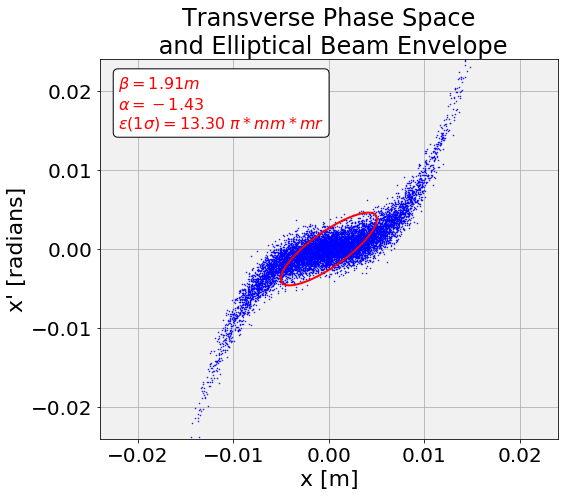

In [105]:
plt.figure(figsize=(8,7))
plt.plot(x0,xp0,'bo',markersize=0.5)
plt.title('Transverse Phase Space\n and Elliptical Beam Envelope',fontsize=24)
plt.xlim(-0.024,0.024)
plt.ylim(-0.024,0.024)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel("x\' [radians]",fontsize=22)
plt.grid()
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.gca().set_facecolor('#f1f1f1')

x_ellipse = np.linspace(-(epsilon*beta)**0.5,(epsilon*beta)**0.5,100)
xp_pos = (1/beta)*(-alpha*x_ellipse + (alpha**2*x_ellipse**2+beta*epsilon-beta*gamma*x_ellipse**2)**0.5)
xp_neg = (1/beta)*(-alpha*x_ellipse - (alpha**2*x_ellipse**2+beta*epsilon-beta*gamma*x_ellipse**2)**0.5)
plt.plot(x_ellipse,xp_pos,'r',linewidth=2)
plt.plot(x_ellipse,xp_neg,'r',linewidth=2)

textstr = r'$\beta = %.2f m$'%(beta)+'\n'+r'$\alpha = %.2f$'%(alpha)+'\n'+r'$\epsilon (1\sigma) = %.2f$'%(epsilon*1E6)+r' $\pi*mm*mr$'

plt.text(0.04, 0.82, textstr, transform=plt.gca().transAxes, fontsize=16, color='red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.tight_layout() 
plt.show()

In [0]:
def beamline(k,x,xp,num_wires,wire_pitch,low_x_lim,high_x_lim):
    L = 1 # drift length [m]
    l = 1 # magnet length [m]
    O = np.array([[1,L],[0,1]])
    F = np.array([[np.cos(k**0.5),(k**-0.5)*np.sin(k**0.5)],[-(k**0.5)*np.sin(k**0.5),np.cos(k**0.5)]])
    D = np.array([[np.cosh(k**0.5),(k**-0.5)*np.sinh(k**0.5)],[-(k**0.5)*np.sinh(k**0.5),np.cosh(k**0.5)]])
    #F = np.array([[1,0],[-k*l,1]])
    #D = np.array([[1,0],[k*l,1]])
    
    R = np.linalg.multi_dot([O,D,O,F,O,D,O,F,O,D,O,F])
    
    xnew = R[0][0]*x + R[0][1]*xp
    xpnew = R[1][0]*x + R[1][1]*xp
    
    binBoundaries = np.linspace(low_x_lim,high_x_lim,num_wires+1)
    plt.clf()
    histarray = plt.hist(xnew,bins=binBoundaries)[0]
    plt.title("Simulated multiwire beam profile")
    plt.xlabel('x [m]')
    plt.ylabel('# of particles')
    plt.grid()
    
    theta = np.arctan(R[0][1]/R[0][0])
    s = np.sqrt(R[0][0]**2+R[0][1]**2)
    
    return xnew, histarray, theta, s

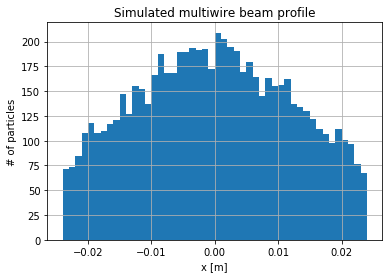

In [107]:
k_array = np.linspace(0.315,0.91,50)
theta_array = []
sarray = []
xarray = []
profiles = []
for k in k_array:
    x, d, th, s = beamline(k,x0,xp0,num_wires,wire_pitch,low_x_lim,high_x_lim)
    theta_array.append(th)
    sarray.append(s)
    xarray.append(x)
    profiles.append(d)

Text(0.5, 1.0, 'Original profiles')

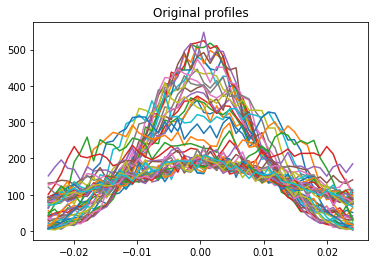

In [108]:
x_axis = np.linspace(-(num_wires/2)*wire_pitch,(num_wires/2)*wire_pitch,num_wires,1)

for p in profiles:
    plt.plot(x_axis,p)
plt.title('Original profiles')

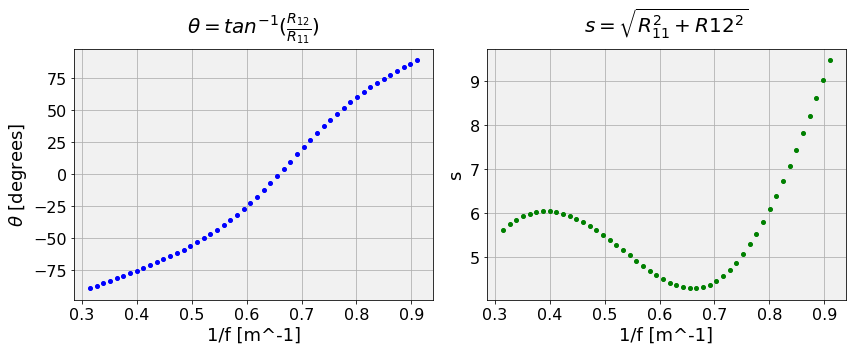

In [109]:
theta_array_degrees = np.asarray(theta_array)*(180/np.pi)
np.save("theta_array_degrees",theta_array_degrees)
np.save("sarray",sarray)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title(r'$\theta = tan^{-1}(\frac{R_{12}}{R_{11}})$',fontsize=20,y=1.04)
plt.plot(k_array,theta_array_degrees,'bo',markersize=4.0);
plt.xlabel('1/f [m^-1]',fontsize=18)
plt.ylabel(r'$\theta$ [degrees]',fontsize=18)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
plt.grid()
plt.gca().set_facecolor('#f1f1f1')


plt.subplot(122)
plt.title(r'$s = \sqrt{R_{11}^2 + R{12}^2}$',fontsize=20,y=1.04)
plt.plot(k_array,sarray,'go',markersize=4.0);
plt.xlabel('1/f [m^-1]',fontsize=18)
plt.ylabel('s',fontsize=18)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
plt.grid()
plt.gca().set_facecolor('#f1f1f1')


plt.tight_layout()

Text(0.5, 1.0, 'Scaled profiles')

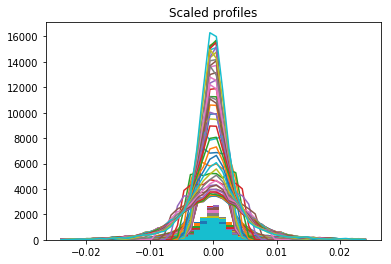

In [110]:
x_axis = np.linspace(-(num_wires/2)*wire_pitch,(num_wires/2)*wire_pitch,num_wires,1)

# Scale the profiles horizontally by 1/s
xscaled = []
for i in range(0,len(xarray),1):
    xscaled.append(plt.hist(xarray[i]/sarray[i],bins=binBoundaries)[0])

# Scale the profiles vertically by s
yscaled = []
for i in range(0,k_array.size,1):
    yscaled.append(np.asarray(xscaled[i])*np.asarray(sarray[i]))
    plt.plot(x_axis,yscaled[i])
plt.title('Scaled profiles')

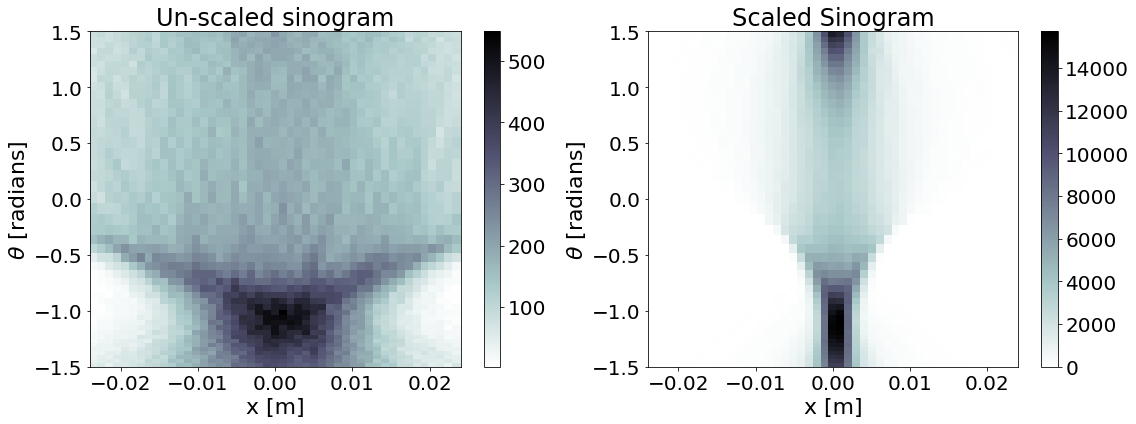

In [111]:
# Generate a sinogram
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Un-scaled sinogram',fontsize=24)
sino_x = x_axis
sino_y = theta_array
xx, yy = np.meshgrid(sino_x,sino_y)
c = np.asarray(profiles)
heatmap = plt.gca().pcolormesh(xx,yy,c,cmap='bone_r');
plt.xlim(low_x_lim,high_x_lim)
plt.ylim(-1.5,1.5)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel(r'$\theta$ [radians]',fontsize=22)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=20)

plt.subplot(122)
plt.title('Scaled Sinogram',fontsize=24)
sino_x = x_axis
sino_y = theta_array
xx, yy = np.meshgrid(sino_x,sino_y)
c = np.asarray(yscaled)
heatmap = plt.gca().pcolormesh(xx,yy,c,cmap='bone_r');
plt.xlim(low_x_lim,high_x_lim)
plt.ylim(-1.5,1.5)
plt.xlabel('x [m]',fontsize=22)
plt.ylabel(r'$\theta$ [radians]',fontsize=22)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

scaled_sino = np.asarray(yscaled)

In [0]:
def plotContour(data):
    xx, yy = np.meshgrid(x_axis,x_axis)
    heatmap = plt.contourf(xx,yy,data,cmap="bone_r")
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    plt.xlabel('x [m]',fontsize=16)
    plt.ylabel("x\' [radians]",fontsize=16)
    plt.grid()

In [0]:
def ellipseFromSecondMoments(low_x_lim,high_x_lim,data):
    binBoundaries = np.linspace(low_x_lim,high_x_lim,48)
    X = []
    Y = []
    x = binBoundaries
    xp = binBoundaries
    for i in range(len(data)): # ith row (xp)
        for j in range(len(data[i])): # jth column (x)
            #if data[i][j] > 0.00225*np.max(data):
            #if data[i][j] > 0.005*np.max(data):
            for k in range(int(10.0*data[i][j])):
                X.append(x[j])
                Y.append(xp[i])
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    s11 = np.mean(X**2)
    s12 = np.mean(X*Y)
    s22 = np.mean(Y**2)
    e = np.sqrt(s11*s22-s12**2)
    
    # Write ellipse equation in form Ax^2+Bx*xp+Cxp^2 = 1
    A = s22/e**2
    B = (-2*s12)/e**2
    C = s11/e**2
    X_coord, Y_coord = np.meshgrid(np.linspace(low_x_lim,high_x_lim,1000), np.linspace(low_x_lim,high_x_lim,1000))
    Z_coord = A*X_coord**2 + B*X_coord*Y_coord + C*Y_coord**2
    plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=1)
    
    # Compute and print Courant-Snyder parameters
    epsilon = (s11*s22 - s12**2)**0.5
    beta = s11/epsilon
    alpha = -s12/epsilon
    gamma = s22/epsilon
    
    textstr = r'$\beta = %.2f m$'%(beta)+'\n'+r'$\alpha = %.2f$'%(alpha)+'\n'+r'$\epsilon (1\sigma) = %.2f$'%(epsilon*1E6)+r' $\pi*mm*mr$'
    plt.text(0.04, 0.82, textstr, transform=plt.gca().transAxes, fontsize=14, color='red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

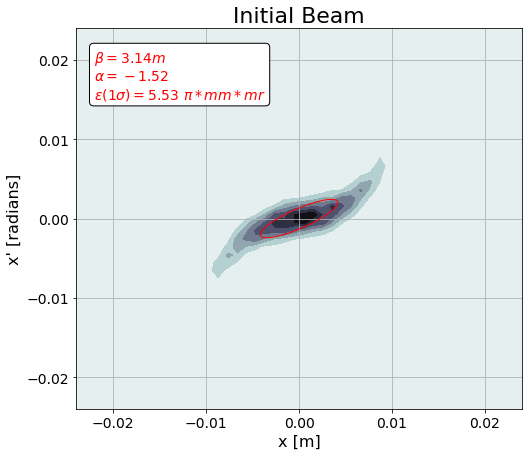

In [114]:
# Make a contour plot of the reference beam distribution
plt.figure(figsize=(8,7))
plt.title('Initial Beam',fontsize=22)
H, x, y = np.histogram2d(x0,xp0,bins=num_wires,normed=True,range=[[low_x_lim, high_x_lim], [low_x_lim, high_x_lim]])
orig_norm = H.T/np.max(H)
plotContour(orig_norm)
ellipseFromSecondMoments(low_x_lim,high_x_lim,orig_norm)

In [0]:
def compute_error(orig_norm,recon_norm):
    error = (orig_norm - recon_norm)
    error_avg = np.sqrt(np.sum(np.asarray(error)**2))
    
    return error, error_avg

In [0]:
def plotError(data):
    xx, yy = np.meshgrid(x_axis,x_axis)
    heatmap = plt.contourf(xx,yy,data,cmap="coolwarm")
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    plt.xlabel('x [m]',fontsize=18)
    plt.ylabel("x\' [radians]",fontsize=18)
    cbar = plt.colorbar(heatmap)
    cbar.ax.tick_params(labelsize=20)
    plt.grid()

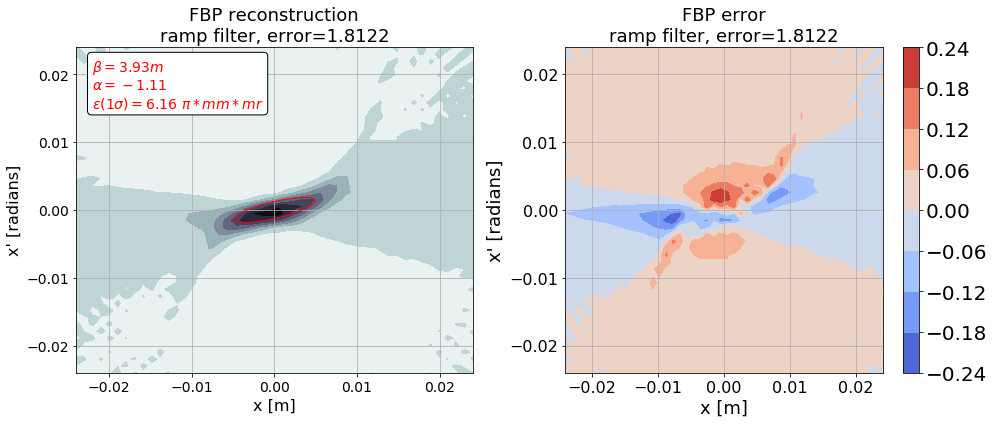

In [117]:
filter = 'ramp'
recon_FBP = iradon(np.asarray(np.transpose(scaled_sino)), theta=theta_array_degrees, output_size=x_axis.size, filter=filter, circle=False)
recon_FBP = np.flipud(np.asarray(recon_FBP))/np.max(recon_FBP)
error_FBP, error_avg_FBP = compute_error(orig_norm,recon_FBP)

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('FBP reconstruction\n'+str(filter)+' filter, '+'error=%.4f'%(error_avg_FBP),fontsize=18)
plotContour(recon_FBP)
ellipseFromSecondMoments(low_x_lim,high_x_lim,recon_FBP)

plt.subplot(122)
plt.title('FBP error\n'+str(filter)+' filter, '+'error=%.4f'%(error_avg_FBP),fontsize=18)
plotError(error_FBP)

plt.tight_layout()

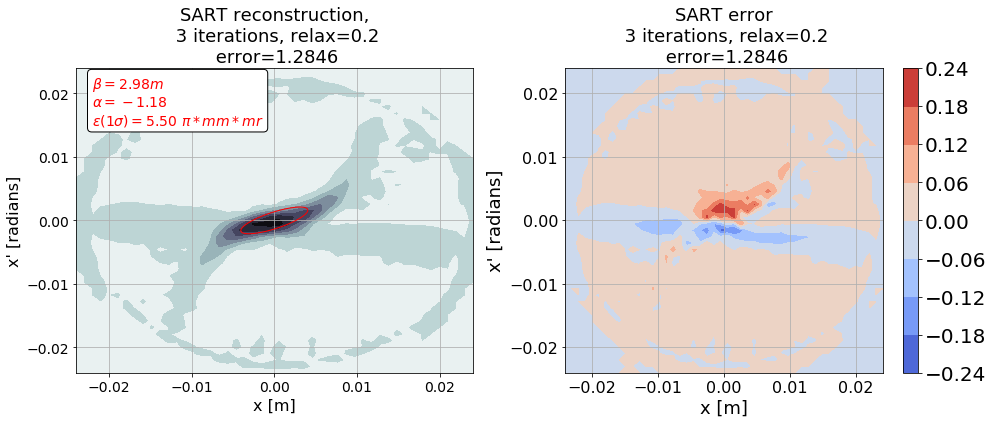

In [118]:
relax = 0.2
num_iterations = 3
recon = np.zeros((x_axis.size,x_axis.size))

for i in range(0,num_iterations,1):
    recon = iradon_sart(np.asarray(np.transpose(scaled_sino)), theta=theta_array_degrees, image=np.flipud(recon), relaxation=relax)
    recon = np.flipud(np.asarray(recon))
recon = recon/np.max(recon)    
error, error_avg = compute_error(orig_norm,recon)

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('SART reconstruction,\n %s iterations, relax=%.1f\n error=%.4f'%(num_iterations,relax,error_avg),fontsize=18)
plotContour(recon)
ellipseFromSecondMoments(low_x_lim,high_x_lim,recon)

plt.subplot(122)
plt.title('SART error\n %s iterations, relax=%.1f\n error=%.4f'%(num_iterations,relax,error_avg),fontsize=18)
plotError(error)

plt.tight_layout()

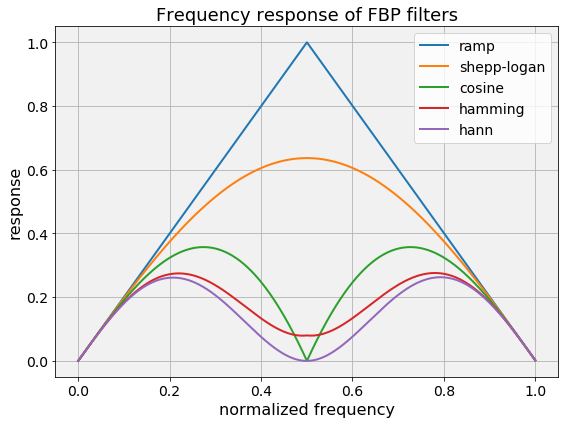

In [209]:
# Show frequency response of filters available to FBP algorithm
# Code found to plot filter response here: https://github.com/scikit-image/scikit-image/issues/2853
def frequency_response(filter):
    
    projection_size_padded = 1024
    f = fftfreq(projection_size_padded).reshape(-1, 1)
    fourier_filter = 2 * np.abs(f)                       # ramp filter
    
    if filter == "ramp":
        pass
    elif filter == "shepp-logan":
        shepp_logan_filter = np.zeros((int(projection_size_padded)))
        shepp_logan_filter[1:] = np.sin(np.pi * np.abs(f[1:,0])) / (np.pi * np.abs(f[1:,0]))
        shepp_logan_filter[0] = 1
        fourier_filter[:,0] *= shepp_logan_filter
        
    elif filter == "cosine":
        freq = 0.5 * np.arange(0,projection_size_padded) / projection_size_padded 
        cosine_filter = np.fft.fftshift(np.sin(2 * np.pi * np.abs(freq)))
        fourier_filter[:,0] *= cosine_filter
    elif filter == "hamming":
        hamming_filter = np.fft.fftshift(np.hamming(projection_size_padded))
        fourier_filter[:,0] *= hamming_filter
    elif filter == "hann":
        hanning_filter = np.fft.fftshift(np.hanning(projection_size_padded))
        fourier_filter[:,0] *= hanning_filter
    elif filter is None:
        fourier_filter[:] = 1
    else:
        raise ValueError("Unknown filter: %s" % filter)
    
    return fourier_filter



filters = [None,'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
fig = plt.figure(figsize=(8,6))

for ix, f in enumerate(filters[1:]):
    response = frequency_response(f)
    plt.plot(np.linspace(0,1,1024),response,label='{}'.format(f),linewidth=2)
    
plt.title('Frequency response of FBP filters',fontsize=18)
plt.xlabel('normalized frequency',fontsize=16)
plt.ylabel('response',fontsize=16)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.gca().set_facecolor('#f1f1f1')
plt.grid()
plt.legend(fontsize=14)
plt.tight_layout()
    
plt.show()    

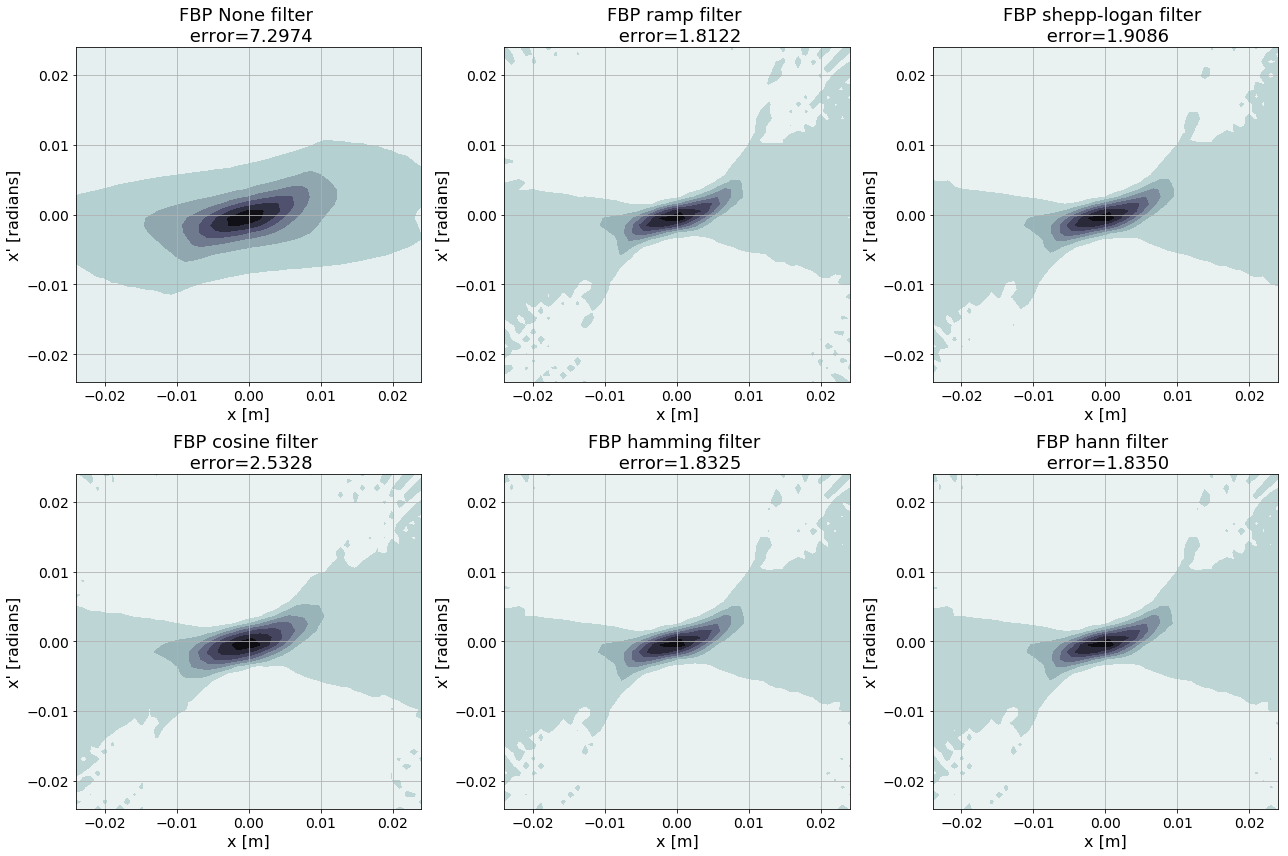

In [201]:
# Plot reconstruction with every FBP filter
fig, ax = plt.subplots(2, int(len(filters)/2), figsize=(18,12))
ax = ax.flatten()
for ix, f in enumerate(filters):
    recon_FBP = iradon(np.asarray(np.transpose(scaled_sino)), theta=theta_array_degrees, output_size=x_axis.size, filter=f, circle=False)
    recon_FBP = np.flipud(np.asarray(recon_FBP))/np.max(recon_FBP)
    error_FBP, error_avg_FBP = compute_error(orig_norm,recon_FBP)

    #ax[ix].set_title('FBP error\n'+str(f)+' filter, '+'error=%.4f'%(error_avg_FBP),fontsize=18)
    ax[ix].set_title('FBP {0} filter \n error={1:.4f}'.format(f,error_avg_FBP),fontsize=18)
    xx, yy = np.meshgrid(x_axis,x_axis)
    heatmap = ax[ix].contourf(xx,yy,recon_FBP,cmap="bone_r")
    for tick in ax[ix].xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax[ix].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    ax[ix].set_xlabel('x [m]',fontsize=16)
    ax[ix].set_ylabel("x\' [radians]",fontsize=16)
    ax[ix].grid()
plt.tight_layout()
plt.show()

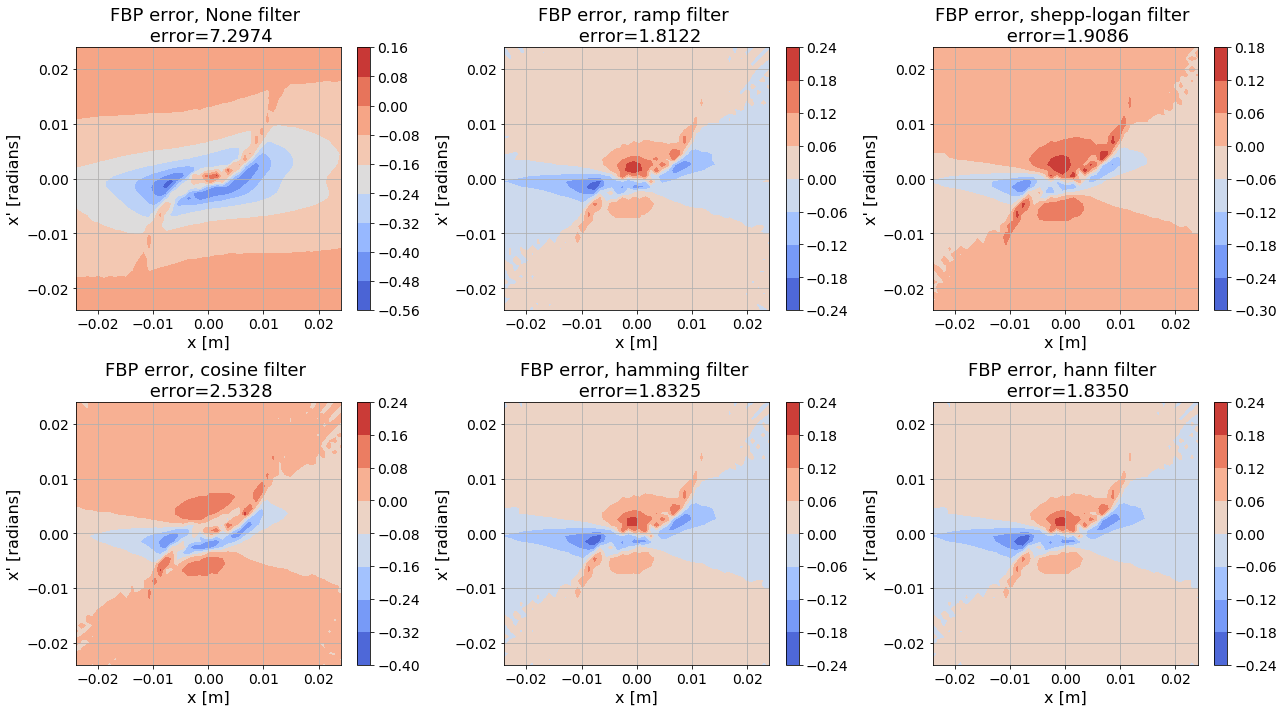

In [205]:
# Plot error image with every FBP filter
fig, ax = plt.subplots(2, int(len(filters)/2), figsize=(18,10))
ax = ax.flatten()
for ix, f in enumerate(filters):
    recon_FBP = iradon(np.asarray(np.transpose(scaled_sino)), theta=theta_array_degrees, output_size=x_axis.size, filter=f, circle=False)
    recon_FBP = np.flipud(np.asarray(recon_FBP))/np.max(recon_FBP)
    error_FBP, error_avg_FBP = compute_error(orig_norm,recon_FBP)

    ax[ix].set_title('FBP error, {0} filter \n error={1:.4f}'.format(f,error_avg_FBP),fontsize=18)
    xx, yy = np.meshgrid(x_axis,x_axis)
    heatmap = ax[ix].contourf(xx,yy,error_FBP,cmap="coolwarm")
    cbar = fig.colorbar(heatmap, ax=ax[ix])
    cbar.ax.tick_params(labelsize=14) 
    for tick in ax[ix].xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax[ix].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    ax[ix].set_xlabel('x [m]',fontsize=16)
    ax[ix].set_ylabel("x\' [radians]",fontsize=16)
    ax[ix].grid()
plt.tight_layout()
plt.show()

In [0]:
# Next step, implement pixel and CS param error vs. relax and iter for SART